In [1]:
#!pip install gym[mujoco]

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.distributions as distributions

# Gym
import gym


## Setup the Environement

In [3]:
env_id = "Humanoid-v4"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.shape[0]

# Agent: Playing MuJoCo Games 🤖
### Please Check The Gym Website for more info about the following Envs

- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

## Let's build the A2C algo


In [4]:
#Using a neural network to learn our actor (policy) parameters

class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size, dtype=torch.float32)
        self.fc2 = nn.Linear(h_size, a_size, dtype=torch.float32)
        self.double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))  # Apply tanh activation for bounded output in [-1, 1]
        return x

    def act(self, state):
        # print('here here')
        # print(state)
        mean = self.forward(state)
        # print('mean')
        # print(mean)
        std_dev = torch.ones_like(mean)  # You might want to learn a parameter for the standard deviation as well
        # print(std_dev)
        distribution = distributions.Normal(mean, std_dev)
        # print(distribution)

        action = distribution.sample()
        # print('action')
        # print(action)
        action = torch.clamp(action, -1.0, 1.0)  # Ensure actions are within the valid range

        # print('log_prob')
        log_prob = distribution.log_prob(action)
        # print(log_prob)

        # print(log_prob)
        return torch.tensor(action), log_prob

In [5]:
#Using a neural network to learn state value
class Critic(nn.Module):

    #Takes in state
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()

        # two fully connected layers
        # add code here
        self.input_layer = nn.Linear(s_size, h_size)
        # add code here
        self.output_layer = nn.Linear(h_size, 1)
        self.double()

    def forward(self, x):

        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value


In [6]:
def computer_cumulative_reward(rewards, max_t,gamma):
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
          disc_return_t = (returns[0] if len(returns)>0 else 0)
          returns.appendleft( rewards[t]+gamma*disc_return_t)
        return returns

In [7]:
def returns_standardization(returns):
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        return returns

In [8]:
def train_critic(criticOptimizer, returns,state_values):
        # print(11)
        state_values= torch.stack(state_values).squeeze()
        # print(12)

        critic_loss= F.mse_loss(torch.tensor(returns, dtype=torch.double), state_values.squeeze())
        #critic_loss = critic_loss.float().clone()

        # print(critic_loss.dtype)

        # Backpropagate crtic
        criticOptimizer.zero_grad()
        critic_loss.backward()
        # print(14)
        criticOptimizer.step()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 2000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [11]:
# Create actor and place it to the device
cartpole_actor = Actor(cartpole_hyperparameters['state_space'],cartpole_hyperparameters['action_space'],cartpole_hyperparameters['h_size'])

cartpole_actorOptimizer = torch.optim.Adam(cartpole_actor.parameters())

In [12]:
# Create critic and place it to the device
cartpole_critic = Critic(cartpole_hyperparameters['state_space'],cartpole_hyperparameters['h_size'])
cartpole_criticOptimizer = torch.optim.Adam(cartpole_critic.parameters())

In [13]:
def generate_trajectory(actor, critic, max_t):
        saved_log_probs = []
        rewards = []
        state_values=[]

        state, _ = env.reset()
        # print(11)
        for t in range(max_t):
            #state=torch.from_numpy(state).float().unsqueeze(0).to(device)
            state = torch.from_numpy(state)

            # print(state)
            action, log_prob =  actor.act(state)
            # print(action)
            #action = torch.from_numpy(action).float().unsqueeze(0).to(device)
            # print(13)

            # get the state value from th critic network
            # print(state)
            state_val= critic(state)#!!!!!!!!!
            # print('state value from critic -----: ')
            # print(state_val)
            # print('after state')
            next_state, reward, done, _, _ = env.step(action.numpy().astype(np.float32))
            # print('next_state---------')
            # print(next_state.dtype)
            # print('reward---------')
            # print(reward.dtype)
            # print('done---------')
            # print(done.dtype)

            # add te obtained results to their relative lists ==> saved_log_probs, rewards, state_values

            # add code here
            saved_log_probs.append(log_prob)
            # print('next_state')
            # print(next_state)
            # print('reward')
            # print(reward)
            # print('rewards')
            # print(rewards)
            # add code here
            rewards.append(reward)
            # print(17)
            # add code here
            state_values.append(state_val)
            # print(18)

            state=next_state
            # print(19)

            if done:
                # print('break ------------------ ',t)
                break

        return  saved_log_probs, rewards, state_values

In [14]:
def Actor_Critic(actor,critic, actorOptimizer,criticOptimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):

        # Generate an episode
        #add code here
        # print('---____----EPISODE---____----- ',i_episode)

        saved_log_probs, rewards, state_values = generate_trajectory(actor, critic, max_t)
        # print(len(state_values), '------LENGTH---------')
        # print(2)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        # print('rewards')
        # print(rewards)
        # print('scores')
        # print(scores)
        # calculate the return
        returns = computer_cumulative_reward(rewards,max_t,gamma)
        # print(3)

        ## standardization of the returns is employed to make training more stable
        returns=returns_standardization(returns)

        # Train the Critic network
        #add code here
        train_critic(criticOptimizer, returns,state_values)
        # print(5)

        # Train the Actor network
        #add code here
        train_actor(actorOptimizer,saved_log_probs, returns,state_values)
        # print(6)



        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [15]:
def train_actor(actorOptimizer,saved_log_probs, returns,state_values):


        # print('train actor ---------------------')
        #state_values = state_values
        state_values= torch.stack(state_values).squeeze()
        # print(state_values)
        #calculate Advantage for actor
        advantages = returns - state_values
        advantages = [g - val for g, val in zip(returns,state_values)]

        #convect the advantages to a tensor
        advantages = torch.Tensor(advantages).to(device)

        actor_loss = []
        # compute the actor loss
        # add code here
        # print(saved_log_probs)
        for log_prob, advantage in zip(saved_log_probs, advantages):
          actor_loss.append(-log_prob * advantage)
          # print('Adv:', advantage)
          # print('Dimensions:', log_prob.shape, advantage.shape)


        # print(actor_loss)
        # print('we are reaching this 0')
        actor_loss = torch.cat(actor_loss).sum()
        # print('we are reaching this 1')
        actorOptimizer.zero_grad()
        # print('we are reaching this 2')
        actor_loss.backward()
        # print('we are not reaching this 3')
        actorOptimizer.step()
        # print('we are not reaching this 4')

In [16]:
scores_mb = Actor_Critic(cartpole_actor,
                   cartpole_critic, cartpole_actorOptimizer,cartpole_criticOptimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

C:\Users\DELL\AppData\Local\Temp\ipykernel_10820\2916603024.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(action), log_prob
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\DELL\AppData\Local\Temp\ipykernel_10820\297310716.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  critic_loss= F.mse_loss(torch.tensor(returns, dtype=torch.double), state_values.squeeze())


Episode 100	Average Score: 146.56
Episode 200	Average Score: 193.45
Episode 300	Average Score: 224.67
Episode 400	Average Score: 319.15
Episode 500	Average Score: 234.04
Episode 600	Average Score: 229.21
Episode 700	Average Score: 273.48
Episode 800	Average Score: 293.05
Episode 900	Average Score: 229.48
Episode 1000	Average Score: 299.69
Episode 1100	Average Score: 304.36
Episode 1200	Average Score: 355.24
Episode 1300	Average Score: 343.53
Episode 1400	Average Score: 338.79
Episode 1500	Average Score: 313.32
Episode 1600	Average Score: 322.16
Episode 1700	Average Score: 322.52
Episode 1800	Average Score: 322.77
Episode 1900	Average Score: 323.37
Episode 2000	Average Score: 324.69


In [17]:
scores_mb= pd.Series(scores_mb, name="scores_Actor")
scores_mb.describe()

count    2000.000000
mean      285.676859
std        95.648418
min        71.395194
25%       221.644593
50%       293.140953
75%       345.637991
max       655.474166
Name: scores_Actor, dtype: float64

In [18]:
scores_mb

0        76.181948
1       147.829468
2       112.593316
3       121.956700
4       139.008376
           ...    
1995    290.288998
1996    283.477401
1997    362.150814
1998    311.650726
1999    344.458405
Name: scores_Actor, Length: 2000, dtype: float64

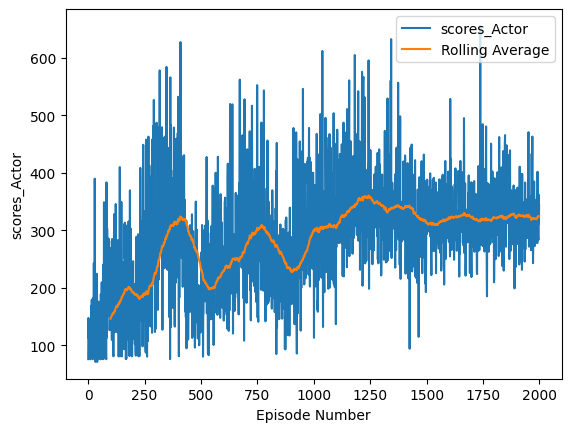

In [19]:
fig, ax = plt.subplots(1, 1)
_ = scores_mb.plot(ax=ax, label="scores_Actor")
_ = (scores_mb.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")

In [20]:
import torch

# Assuming 'model' is your trained PyTorch model
actor_path = './'+ env_id+ '/actor.pth'
torch.save(cartpole_actor, actor_path)
critic_path = './'+ env_id+ '/critic.pth'
torch.save(cartpole_critic, critic_path)


In [21]:
import torch

# Assuming 'model' is your trained PyTorch model
actor_path = './'+ env_id+ '/actor_free.pth'
torch.save(cartpole_actor, actor_path)
critic_path = './'+ env_id+ '/critic_free.pth'
torch.save(cartpole_critic, critic_path)

In [23]:
import os
import imageio
import gym
from base64 import b64encode
from IPython.display import HTML

def generate_trajectory_with_frames(actor, critic, env, max_t):
    saved_log_probs = []
    rewards = []
    state_values = []

    state, _ = env.reset()
    frames = []  # List to store frames

    for t in range(max_t):
        state = torch.from_numpy(state)

        action, log_prob = actor.act(state)

        # get the state value from the critic network
        state_val = critic(state)

        next_state, reward, done, _, _ = env.step(action.numpy().astype(np.float32))
        frames.append(env.render())

        # add the obtained results to their relative lists ==> saved_log_probs, rewards, state_values
        saved_log_probs.append(log_prob)
        rewards.append(reward)
        state_values.append(state_val)

        state = next_state

        if done:
            break

    return saved_log_probs, rewards, state_values, frames


try:
    os.environ["DISPLAY"]
except:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

env = gym.make(env_id, render_mode="rgb_array")
_, _, _, images = generate_trajectory_with_frames(cartpole_actor, cartpole_critic, env.unwrapped, 1000)
print(len(images))

def record_video(images, out_directory, fps=60):
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

# generate the video
video_path = "./replay"+str(len(images))+".mp4"
record_video(images, video_path, 10)


C:\Users\DELL\AppData\Local\Temp\ipykernel_10820\2916603024.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(action), log_prob


78
